This notebook is part of the *orix* documentation https://orix.readthedocs.io. Links to the documentation won’t work from the notebook.

# Crystal map

In this tutorial we will create, load and save crystallographic mapping data and learn how to access and modify with the data and visualize it. All interactions with this type of data is done with the [orix.crystal_map.CrystalMap](../reference/generated/orix.crystal_map.CrystalMap.rst) class.

There are more examples of using crystal maps in the [Examples section](../examples/index.rst#Crystal-maps).

Orientations and other properties acquired from a super-duplex stainless steel (SDSS) EBSD data set with two phases, austenite and ferrite, are used as example data. The data can be downloaded to your local cache via the [orix.data](../reference/generated/orix.data.rst) module, courtesy of Prof. Jarle Hjelen from the Norwegian University of Science and Technology.

In [1]:
%matplotlib inline

import tempfile

from diffpy.structure import Atom, Lattice, Structure
import matplotlib.pyplot as plt
import numpy as np

from orix import data, io, plot
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d


plt.rcParams.update({"figure.figsize": (7, 7), "font.size": 15})
tempdir = tempfile.mkdtemp() + "/"

## Load, create and save

A CrystalMap instance can be obtained by reading an orientation data set stored in a format supported by orix using the [orix.io.load()](../reference/generated/orix.io.load.rst) function, or by passing the necessary arrays when creating the the [CrystalMap()](../reference/generated/orix.crystal_map.CrystalMap.rst) method. Three file formats are supported, in addition to orix's own HDF5 format: Data in the .ang format produced by the softwares EDAX TSL OIM Data Collection v7, NanoMegas ASTAR Index, and EMsoft v4/v5 via the `EMdpmerge` program, data in EMsoft v4/v5 HDF5 files produced by the `EMEBSDDI` program, and data in Bruker's HDF5 files resulting from Hough indexing.

Two writers are supported, namely orix's own HDF5 format, readable by orix and any HDF5 file viewer, and the .ang format, readable at least by MTEX and EDAX TSL OIM Analysis v7.

### Load or create

Let's load a small crystal map from an .ang file produced with EMsoft. We have to explicitly allow download from an external source.

In [2]:
xmap = data.sdss_ferrite_austenite(allow_download=True)
xmap

Phase   Orientations       Name  Space group  Point group  Proper point group       Color
    1   5657 (48.4%)  austenite         None          432                 432    tab:blue
    2   6043 (51.6%)    ferrite         None          432                 432  tab:orange
Properties: iq, dp
Scan unit: um

Let's inspect the data and plot it

Phase   Orientations       Name  Space group  Point group  Proper point group       Color
    1   5657 (48.4%)  austenite         None          432                 432    tab:blue
    2   6043 (51.6%)    ferrite         None          432                 432  tab:orange
Properties: iq, dp
Scan unit: um

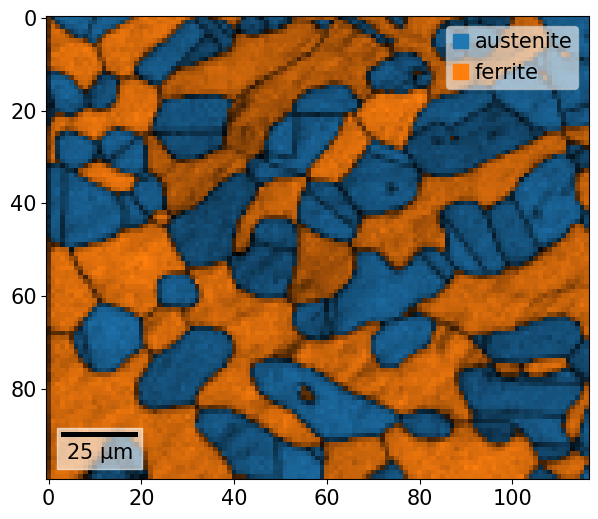

In [3]:
xmap.plot(
    overlay="dp"
)  # Dot product values added to the alpha (RGBA) channel
xmap

The indexing properties returned by EMsoft in their .ang files are the pattern image quality (iq) (according to Niels Krieger Lassen's method), and the highest normalized dot product (dp) between the experimental and best matching simulated pattern.

The same `CrystalMap` object can be obtained by reading each array from the .ang file ourselves and passing this to `CrystalMap.__init__()`

In [4]:
# Directly access *private* cache data path from module
from orix.data._data import _fetcher

_target = _fetcher.path / "sdss/sdss_ferrite_austenite.ang"

# Read each column from the file
eu1, eu2, eu3, x, y, iq, dp, phase_id = np.loadtxt(_target, unpack=True)

# Create a Rotation object from Euler angles
euler_angles = np.column_stack((eu1, eu2, eu3))
rotations = Rotation.from_euler(euler_angles)

# Create a property dictionary
properties = dict(iq=iq, dp=dp)

# Create unit cells of the phases
structures = [
    Structure(
        title="austenite",
        atoms=[Atom("fe", [0] * 3)],
        lattice=Lattice(0.360, 0.360, 0.360, 90, 90, 90),
    ),
    Structure(
        title="ferrite",
        atoms=[Atom("fe", [0] * 3)],
        lattice=Lattice(0.287, 0.287, 0.287, 90, 90, 90),
    ),
]
phase_list = PhaseList(
    names=["austenite", "ferrite"],
    point_groups=["432", "432"],
    structures=structures,
)

# Create a CrystalMap instance
xmap2 = CrystalMap(
    rotations=rotations,
    phase_id=phase_id,
    x=x,
    y=y,
    phase_list=phase_list,
    prop=properties,
)
xmap2.scan_unit = "um"

xmap2

Phase   Orientations       Name  Space group  Point group  Proper point group       Color
    1   5657 (48.4%)  austenite         None          432                 432    tab:blue
    2   6043 (51.6%)    ferrite         None          432                 432  tab:orange
Properties: iq, dp
Scan unit: um

### Save

#### orix HDF5 format

As mentioned, the two writers implemented are orix's own HDF5 format and the .ang format, used by calling [orix.io.save()](../reference/generated/orix.io.save.rst)

In [5]:
io.save(
    filename=tempdir + "sdss_ferrite_austenite2.h5",
    object2write=xmap,
    overwrite=True,  # Default is False
)

Read the file contents back into a `CrystalMap` object using [orix.io.load()](../reference/generated/orix.io.load.rst) function.

All contents in this file can be inspected using any HDF5 viewer and read back into Python using the h5py library (which we use).

#### .ang format

The .ang writer supports many use cases. Some of these are demonstrated here, by reloading the saved crystal maps.

First, let's write the multi phase map to an .ang file, specifying that the `xmap.dp` property should be written to the confidence index (CI) column

In [6]:
fname_ang1 = "sdss_dp_ci.ang"
io.save(
    filename=tempdir + fname_ang1,
    object2write=xmap,
    confidence_index_prop="dp",
)

xmap_reload1 = io.load(tempdir + fname_ang1)
print(xmap_reload1)
print(xmap_reload1.prop)

autogenerating phase names...
Changing Phase 1 name from 'austenite' to 'austenite'
Changing Phase 2 name from 'ferrite' to 'ferrite'
Phase   Orientations       Name  Space group  Point group  Proper point group       Color
    1   5657 (48.4%)  austenite         None          432                 432  tab:orange
    2   6043 (51.6%)    ferrite         None          432                 432    tab:blue
Properties: iq, ci, detector_signal, fit
Scan unit: um
{'iq': array([24.4, 24. , 30.3, ..., 25.3, 25.8, 31.7], shape=(11700,)), 'ci': array([0.799, 0.797, 0.825, ..., 0.817, 0.809, 0.828], shape=(11700,)), 'detector_signal': array([0., 0., 0., ..., 0., 0., 0.], shape=(11700,)), 'fit': array([0., 0., 0., ..., 0., 0., 0.], shape=(11700,))}


Note that points not in data are set to `not_indexed` when reloaded from the .ang file, and that all properties in points not in the data set are set to zero, except for the CI column where this property in points not in the data (the austenite points) are set to -1, which MTEX and EDAX TSL expects in these points.

Finally, it is worth mentioning that if a map has more than one rotation/match and phase ID per point, the index parameter can be passed to write any "layer" of the data to file.

## Modify crystal phases

The phases are stored in a  [PhaseList](../reference/generated/orix.crystal_map.PhaseList.rst) instance in the `CrystalMap.phases` attribute. Details on how to load, modify, overwrite, and otherwise utilize both Phases and PhaseList can be found in the [Examples Gallery](../../examples/phases).

In [7]:
xmap.phases[1].space_group = 225
xmap.phases[2].space_group = 229
xmap.phases["austenite"].structure = Structure(
    lattice=Lattice(0.36, 0.36, 0.36, 90, 90, 90)
)
xmap.phases["austenite"].color = "lime"  # Sets RGB tuple (0, 1, 0)
print(xmap.phases["austenite"].color_rgb)

xmap.phases

(0.0, 1.0, 0.0)


Id       Name  Space group  Point group  Proper point group       Color
 1  austenite        Fm-3m         m-3m                 432        lime
 2    ferrite        Im-3m         m-3m                 432  tab:orange

If some data points are considered as not indexed, a "not_indexed" phase can be added to the phase list to keep track of these points

In [8]:
xmap.phases.add_not_indexed()

xmap.phases

Id         Name  Space group  Point group  Proper point group       Color
-1  not_indexed         None         None                None       white
 1    austenite        Fm-3m         m-3m                 432        lime
 2      ferrite        Im-3m         m-3m                 432  tab:orange

No points in this data set are considered not indexed. A phase list with only the phases in the data is stored in the `phases_in_data` attribute

In [9]:
xmap.phases_in_data

Id       Name  Space group  Point group  Proper point group       Color
 1  austenite        Fm-3m         m-3m                 432        lime
 2    ferrite        Im-3m         m-3m                 432  tab:orange

We can of course remove a phase from the phase list, either by its name or phase ID

In [10]:
del xmap.phases[-1]

xmap.phases

Id       Name  Space group  Point group  Proper point group       Color
 1  austenite        Fm-3m         m-3m                 432        lime
 2    ferrite        Im-3m         m-3m                 432  tab:orange

## Orientation data

Rotations are stored in a  [Rotation](../reference/generated/orix.quaternion.Rotation.rst) instance

In [11]:
xmap.rotations

Rotation (11700,)
[[ 0.9358  0.3191  0.0919 -0.1185]
 [ 0.8686  0.3569 -0.2749 -0.2064]
 [ 0.8681  0.3581 -0.2744 -0.2068]
 ...
 [ 0.9126 -0.3022 -0.1552  0.2275]
 [ 0.8854  0.3337 -0.2385  0.2187]
 [ 0.885   0.3341 -0.2391  0.2193]]

Orientations *per phase* can be obtained by applying the phase point group symmetry

In [12]:
O_au = xmap["austenite"].orientations

O_au

Orientation (5657,) m-3m
[[ 0.8686  0.3569 -0.2749 -0.2064]
 [ 0.8681  0.3581 -0.2744 -0.2068]
 [ 0.8684  0.3578 -0.2751 -0.2052]
 ...
 [ 0.9639  0.022   0.0754 -0.2545]
 [ 0.8854  0.3337 -0.2385  0.2187]
 [ 0.885   0.3341 -0.2391  0.2193]]

The above is equivalent to

In [13]:
R_au = xmap["austenite"].rotations
O_au2 = Orientation(R_au, symmetry=xmap["austenite"].phases[1].point_group)

Orientation angles and axes are readily available

In [14]:
O_au.angle

array([1.03696736, 1.0386825 , 1.03750937, ..., 0.53910283, 0.96693885,
       0.96880627], shape=(5657,))

In [15]:
O_au.axis

Vector3d (5657,)
[[ 0.7202 -0.5548 -0.4166]
 [ 0.7215 -0.5529 -0.4167]
 [ 0.7217 -0.5549 -0.4139]
 ...
 [ 0.0826  0.283  -0.9556]
 [ 0.7179 -0.5131  0.4705]
 [ 0.7174 -0.5135  0.4708]]

## Map properties

Map properties are stored in the `CrystalMap.prop` attribute dictionary

In [16]:
xmap.prop

{'iq': array([24.4, 24. , 30.3, ..., 25.3, 25.8, 31.7], shape=(11700,)),
 'dp': array([0.799, 0.797, 0.825, ..., 0.817, 0.809, 0.828], shape=(11700,))}

All properties in this dictionary are also available directly from the `CrystalMap` as attributes

In [17]:
xmap.iq

array([24.4, 24. , 30.3, ..., 25.3, 25.8, 31.7], shape=(11700,))

In [18]:
xmap.dp

array([0.799, 0.797, 0.825, ..., 0.817, 0.809, 0.828], shape=(11700,))

We can add a map property by specifying its name and an initial value in each map point

In [19]:
xmap.prop["grain_boundary"] = 0

xmap.grain_boundary

array([0, 0, 0, ..., 0, 0, 0], shape=(11700,))

In [20]:
xmap.prop["grain_boundary2"] = np.arange(xmap.size, dtype=int)

xmap.grain_boundary2

array([    0,     1,     2, ..., 11697, 11698, 11699], shape=(11700,))

We can also delete a property from the `prop` dictionary

In [21]:
del xmap.prop["grain_boundary2"]

xmap.prop

{'iq': array([24.4, 24. , 30.3, ..., 25.3, 25.8, 31.7], shape=(11700,)),
 'dp': array([0.799, 0.797, 0.825, ..., 0.817, 0.809, 0.828], shape=(11700,)),
 'grain_boundary': array([0, 0, 0, ..., 0, 0, 0], shape=(11700,))}

## Plotting

Map plotting can either be done via the [CrystalMap.plot()](../reference/generated/orix.crystal_map.CrystalMap.plot.rst) method, or via the [CrystalMapPlot](../reference/generated/orix.plot.CrystalMapPlot.rst) `matplotlib` projection. To plot a phase map via `CrystalMap.plot()`, we simply do

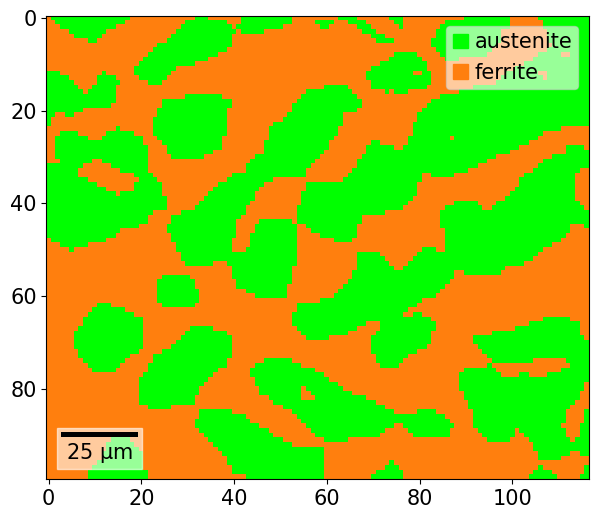

In [22]:
xmap.plot()

Using the `matplotlib` projection

In [23]:
# fig, ax = plt.subplots(subplot_kw=dict(projection="plot_map"))
# im = ax.plot_map(xmap)

Hover over figure points to display the (x,y) position and orientations in that point when plotting interactively!

Note that `plot()` wraps `matplotlib.axes.Axes.imshow`. All key word arguments in `plot()` are passed to `imshow()`, so be sure to check [its documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) out for any additional arguments.

If we obtain a colour per orientation using [IPFColorKeyTSL.orientation2color()](../reference/generated/orix.plot.IPFColorKeyTSL.orientation2color.rst) (see also the [inverse pole figure tutorial](inverse_pole_figures.rst)), we can plot this as well

In [24]:
ckey_m3m = plot.IPFColorKeyTSL(
    xmap.phases["austenite"].point_group, direction=Vector3d.zvector()
)
rgb_au = ckey_m3m.orientation2color(xmap["austenite"].orientations)
rgb_fe = ckey_m3m.orientation2color(xmap["ferrite"].orientations)

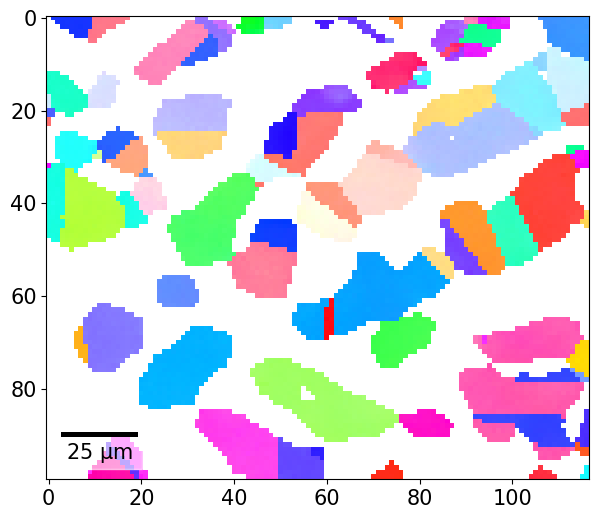

In [25]:
xmap["austenite"].plot(rgb_au)

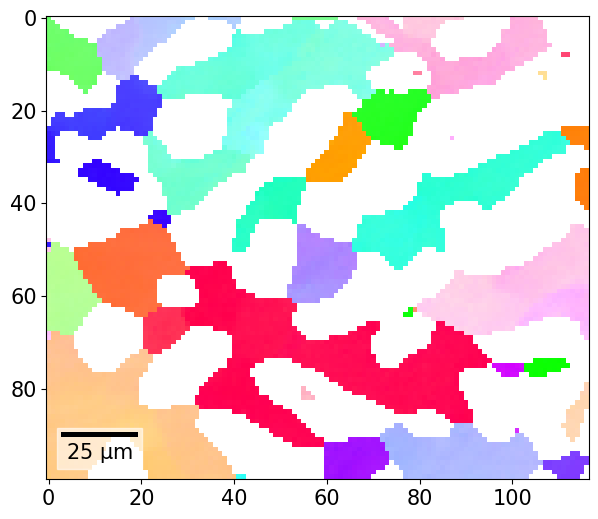

In [26]:
xmap["ferrite"].plot(rgb_fe)

And the combined plot with the IPF color key added to the figure:

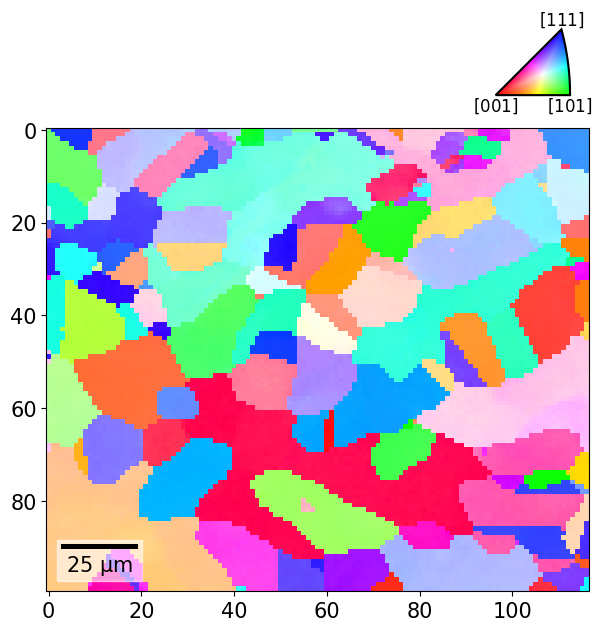

In [27]:
rgb_all = np.zeros((xmap.size, 3))
rgb_all[xmap.phase_id == 1] = rgb_au
rgb_all[xmap.phase_id == 2] = rgb_fe

fig = xmap.plot(rgb_all, return_figure=True)

rc = {"font.size": 8}
with plt.rc_context(rc):  # Temporarily reduce font size
    ax_ipfkey = fig.add_axes(
        [0.72, 0.87, 0.2, 0.1],
        projection="ipf",
        symmetry=xmap.phases["austenite"].point_group,
    )
    ax_ipfkey.plot_ipf_color_key()
    ax_ipfkey.set_title("")

We can also color orientations from their Euler angles using [EulerColorKey.orientation2color()](../reference/generated/orix.plot.EulerColorKey.orientation2color.rst)

In [28]:
ckey_euler = plot.EulerColorKey(xmap.phases["austenite"].point_group)
rgb_au_euler = ckey_euler.orientation2color(xmap["austenite"].orientations)
rgb_fe_euler = ckey_euler.orientation2color(xmap["ferrite"].orientations)

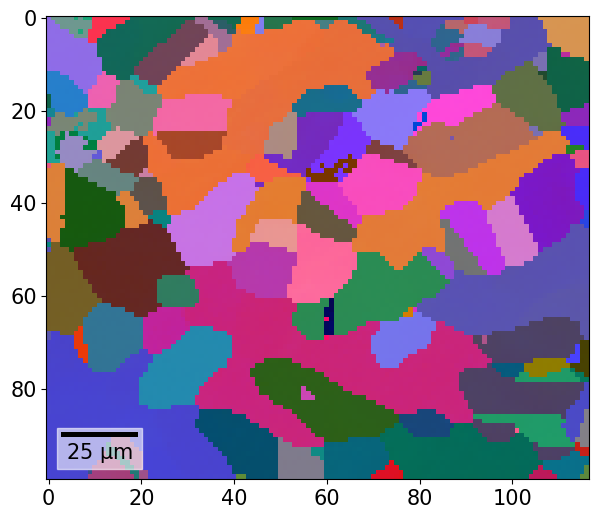

In [29]:
rgb_all_euler = np.zeros((xmap.size, 3))
rgb_all_euler[xmap.phase_id == 1] = rgb_au_euler
rgb_all_euler[xmap.phase_id == 2] = rgb_fe_euler

xmap.plot(rgb_all_euler)

We can plot the color key to see the fundamental Euler region for point group *432*

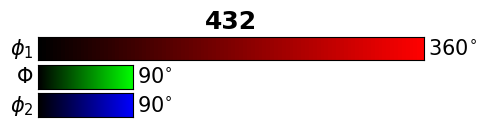

In [30]:
ckey_euler.plot()

We can add any overlay, from any property with a value in each map point, to the map by either passing the property name as a string, or the actual (flattened) array

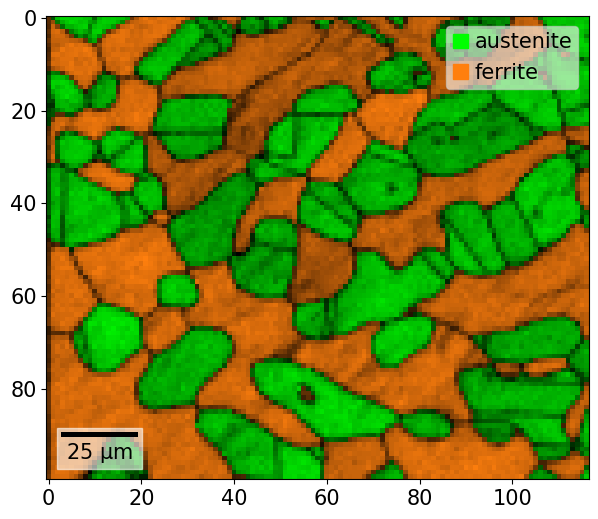

In [31]:
xmap.plot(overlay=xmap.dp)

To save our phase map with the scalebar and legend, but without white padding

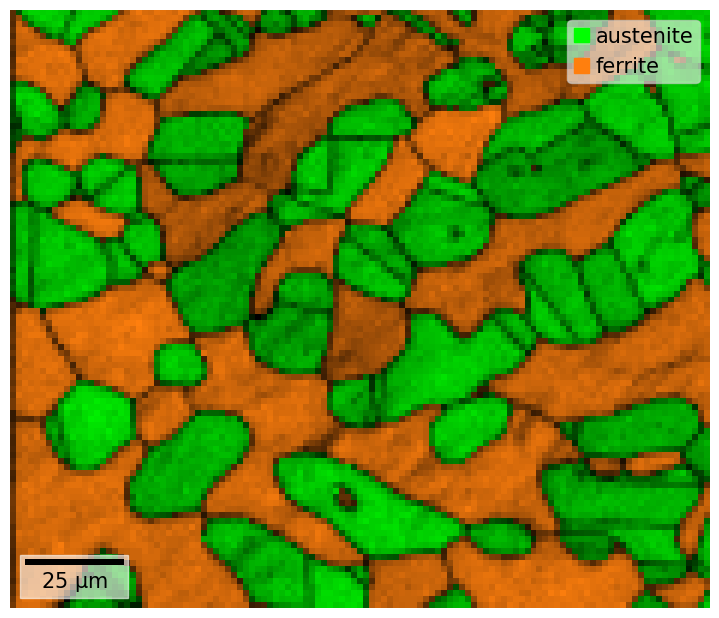

In [32]:
fig = xmap.plot(overlay="dp", return_figure=True, remove_padding=True)
fig.savefig(tempdir + "phase_map.png", bbox_inches="tight", pad_inches=0)

To save phase map without a scalebar, legend and white padding, and one image pixel per map point

In [33]:
ax = fig.axes[0]
ax

<CrystalMapPlot: >

In [34]:
# 2D NumPy array, possibly with an RGB tuple in each element
plt.imsave(tempdir + "phase_map_no_fluff.png", arr=ax.images[0].get_array())

We can plot any property with a value in each map point, also adding a colorbar

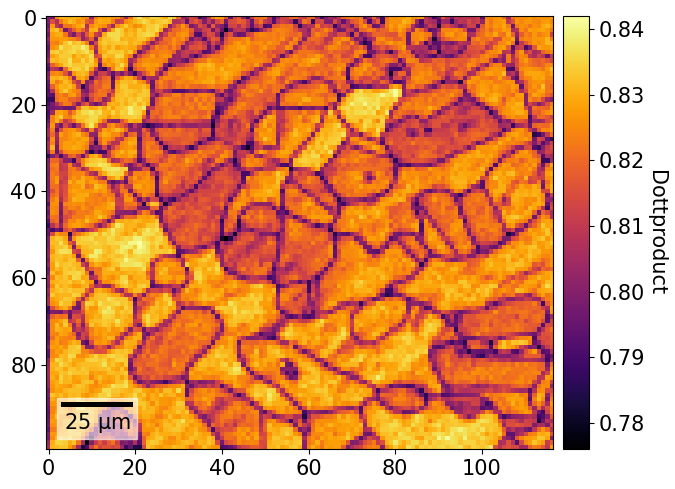

In [35]:
fig = xmap.plot(
    xmap.dp,
    cmap="inferno",
    colorbar=True,
    colorbar_label="Dottproduct",
    return_figure=True,
)

We can update the colorbar

In [36]:
cbar = fig.axes[0].colorbar
cbar

In [37]:
cbar.ax.set_ylabel("Dot product");

We can also plot orientation related values, like axis and angles etc., and restrict the color bar maximum

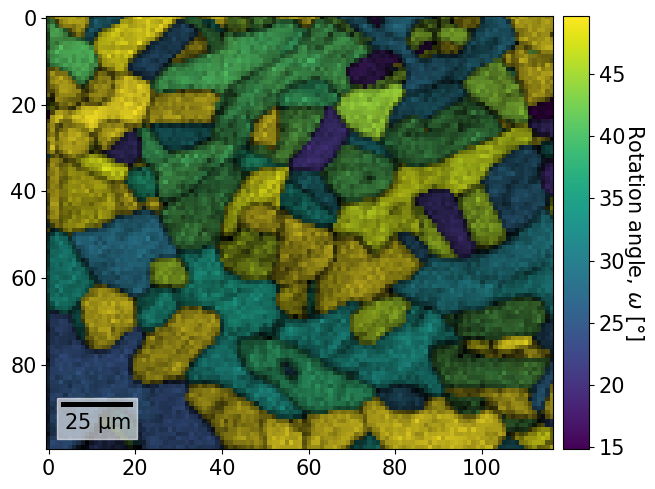

In [38]:
# Get rotation angles in degrees
angles = xmap.rotations.angle * 180 / np.pi

xmap.plot(
    angles,
    vmax=angles.max() - 10,
    overlay=xmap.iq,
    colorbar=True,
    colorbar_label=r"Rotation angle, $\omega$ [$\degree$]",
)

To plot only one phase, while passing custom
* scalebar properties (https://github.com/ppinard/matplotlib-scalebar/)
* legend properties (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)

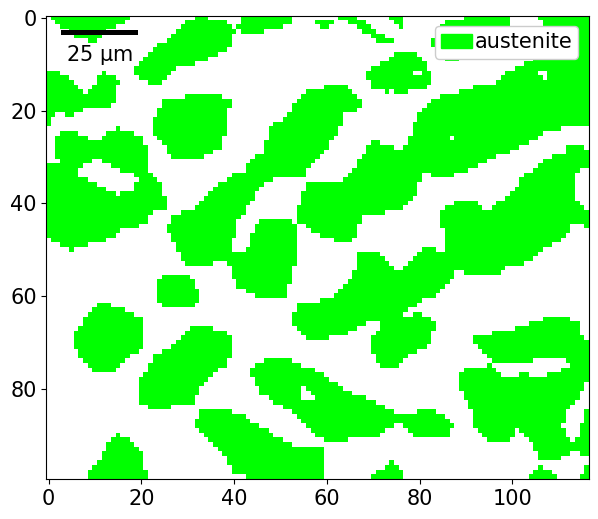

In [39]:
xmap["austenite"].plot(
    scalebar_properties=dict(location="upper left", frameon=False, sep=6),
    legend_properties=dict(
        framealpha=1, handlelength=1.5, handletextpad=0.1
    ),
)

Plot only a rectangle of the map

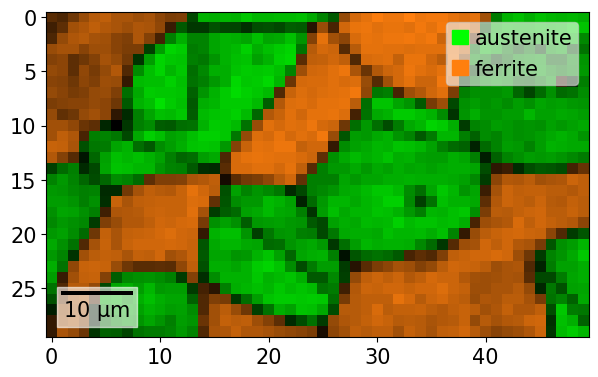

In [40]:
xmap2 = xmap[20:50, 40:90]
xmap2.plot(overlay=xmap2.dp)

Plot only parts of a map based on chained conditionals, like belonging to one phase or having a property value above a threshold

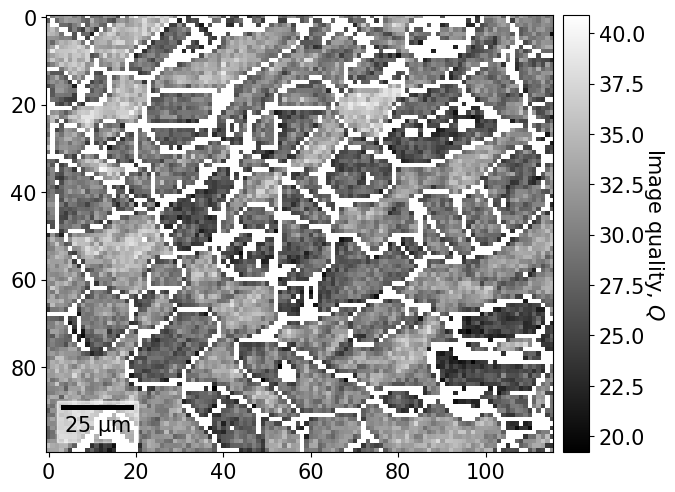

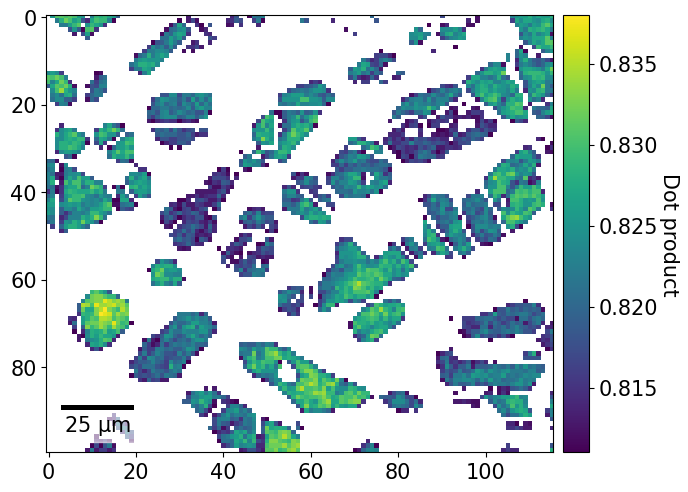

In [41]:
# Conditional slicing
xmap[xmap.dp > 0.81].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

# Chained conditional slicing
xmap[(xmap.dp > 0.81) & (xmap.phase_id == 1)].plot(
    "dp", cmap="viridis", colorbar=True, colorbar_label="Dot product"
)

Plot histogram of a property per phase

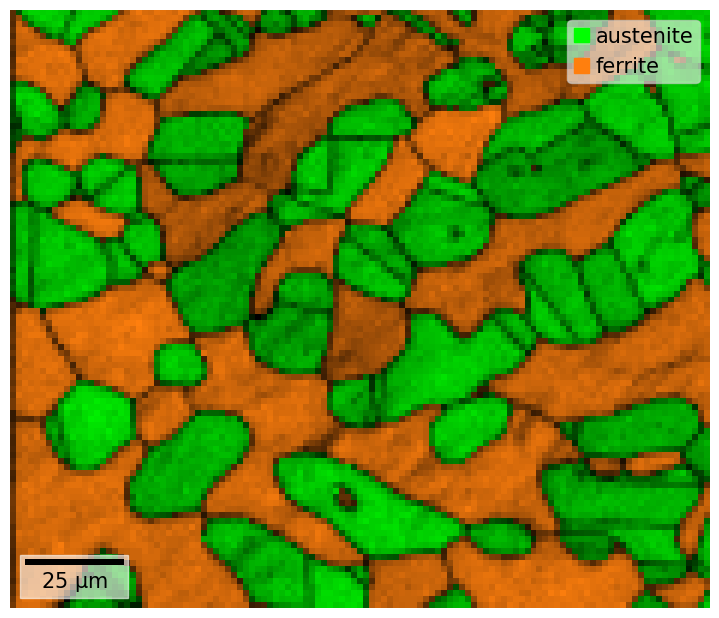

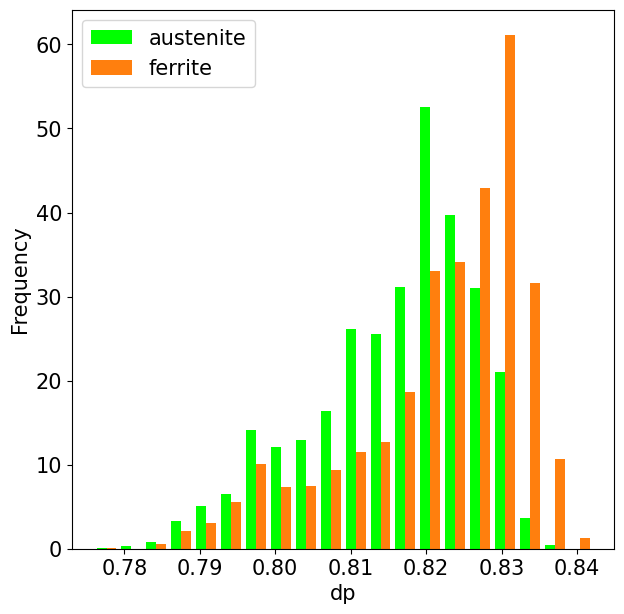

In [42]:
# Property of interest
this_prop = "dp"

# Plot phase map again to see color changes
xmap.plot(overlay=this_prop, remove_padding=True)

# Declare lists for plotting
data = []
labels = []
colors = []

# Get property values, name and color per phase
for _, p in xmap.phases_in_data:
    labels.append(p.name)
    colors.append(p.color)

    # Accessing the property dictionary directly
    data.append(xmap[p.name].prop[this_prop])
    # or indirectly
    # data.append(xmap[p.name].dp)

# Nice bar plot with property histogram per phase
fig, ax = plt.subplots()
ax.hist(
    data, bins=20, histtype="bar", density=True, label=labels, color=colors
)
ax.set_xlabel(this_prop)
ax.set_ylabel("Frequency")
ax.legend();

In [43]:
# Remove files written to disk in this tutorial
import os

for f in [
    tempdir + "sdss_ferrite_austenite2.h5",
    tempdir + "sdss_dp_ci.ang",
    tempdir + "phase_map.png",
    tempdir + "phase_map_no_fluff.png",
]:
    os.remove(f)
os.rmdir(tempdir)